# A Pairs Trading strategy boosted with AI

This notebook explores a pairs trading strategy fueled by AI innovative techniques. This projected is being developed as part of a master thesis for the degree of Electrical and Computer Engineering.

## Dependencies

This notebook requires code from:
    
- `class_SeriesAnalyser.py` - contains a set of functions to deal with time series analysis.
- `class_Trader.py` - contains a set of functions concerning trading strategies.
- `class_DataProcessor.py` - contains a set of functions concerning the data pre processing.

As a good practise, the notebook solely intends to exemplify the application of different trading strategies for different dataset examples, rather than coding the strategies theirselves. Please look into the files menitoned above for more detailed info on how the functions are built.

## Table of Contents
    
    1. Commodity ETFs - entire workflow application example

### Import Libraries

In [280]:
import numpy as np
import pandas as pd

import json

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Import Datetime and the Pandas DataReader
from datetime import datetime
from pandas_datareader import data, wb

# Import alpha vantage
from alpha_vantage.timeseries import TimeSeries

# Import scikit instruments
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing
from sklearn.metrics import silhouette_score

# just set the seed for the random number generator
np.random.seed(107)

In [281]:
ts = TimeSeries(key='MM44549W9ALMWMU0', output_format='pandas')

### Import Configurations

In [248]:
with open('config/config_commodities_long.json', 'r') as f:
    config = json.load(f)

### Import Classes

In [249]:
%load_ext autoreload
%aimport class_SeriesAnalyser, class_Trader, class_DataProcessor
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [250]:
series_analyzer = class_SeriesAnalyser.SeriesAnalyser()
trader = class_Trader.Trader()
data_processor = class_DataProcessor.DataProcessor(path=config['dataset']['path'])

# 1. Commodity ETFs Dataset

In this section, we proceed to analyze ETFs from different commodity sectors and detect possible interesting pairs. The process goes as follows:

- Upload time series corresponding to ETFs
- Apply dimensionality reduction and cluster securities
- Run cointegration tests for securities within the same cluster

In [251]:
etfs, etfs_unique, tickers = data_processor.read_ticker_excel(ticker_attribute=config['dataset']['ticker_attribute'])

In [252]:
duplicated_etfs = etfs[etfs.duplicated(subset=['Ticker'], keep=False)].sort_values(['Ticker'])
duplicated_etfs

,Sector,Ticker,Description,Issuer,AUM,ExpenseRatio,3-MO TR,Segment
59,Commodity,AAAU,Perth Mint Physical Gold ETF,Exchange Traded Concepts,$108.72M,0.18%,4.10%,Commodities: Precious Metals Gold
339,Precious Metals,AAAU,Perth Mint Physical Gold ETF,Exchange Traded Concepts,$108.72M,0.18%,4.10%,Commodities: Precious Metals Gold
232,Gold,AAAU,Perth Mint Physical Gold ETF,Exchange Traded Concepts,$108.72M,0.18%,4.10%,Commodities: Precious Metals Gold
137,Commodity,AGF,DB Agriculture Long ETN,Deutsche Bank,$716.83K,0.75%,NaN,Commodities: Agriculture
17,Agriculture,AGF,DB Agriculture Long ETN,Deutsche Bank,$716.83K,0.75%,NaN,Commodities: Agriculture
48,Commodity,AGQ,ProShares Ultra Silver,ProShares,$183.61M,5.28%,7.49%,Leveraged Commodities: Precious Metals Silver
362,Silver,AGQ,ProShares Ultra Silver,ProShares,$183.61M,5.28%,7.49%,Leveraged Commodities: Precious Metals Silver
334,Precious Metals,AGQ,ProShares Ultra Silver,ProShares,$183.61M,5.28%,7.49%,Leveraged Commodities: Precious Metals Silver
102,Commodity,BAL,iPath Series B Bloomberg Cotton Subindex Total...,Barclays Bank PLC,$8.84M,0.45%,5.30%,Commodities: Agriculture Cotton
152,Cotton,BAL,iPath Series B Bloomberg Cotton Subindex Total...,Barclays Bank PLC,$8.84M,0.45%,5.30%,Commodities: Agriculture Cotton


In [253]:
etfs_unique.Segment.value_counts()

Equity: U.S. MLPs                                            25
Commodities: Broad Market                                    21
Commodities: Precious Metals Gold                            12
Equity: U.S. Energy                                          11
Commodities: Energy Crude Oil                                10
Equity: Global Gold Miners                                    7
Commodities: Agriculture                                      7
Inverse Commodities: Energy Crude Oil                         7
Equity: Global Metals & Mining                                5
Commodities: Precious Metals Silver                           5
Equity: Global Water                                          5
Leveraged Commodities: Energy Crude Oil                       5
Commodities: Energy                                           4
Inverse Commodities: Precious Metals Gold                     4
Equity: U.S. Oil & Gas Exploration & Production               3
Inverse Equity: U.S. Energy             

In [254]:
dataset = data_processor.read_tickers_prices(tickers=tickers,
                                             initial_date=config['dataset']['initial_date'],
                                             final_date=config['dataset']['final_date'],
                                             data_source=config['dataset']['data_source']
                                            )

Not Possible to retrieve information for AAAU
Not Possible to retrieve information for BATT
Not Possible to retrieve information for CMDY
Not Possible to retrieve information for GLDM
Not Possible to retrieve information for IAUF
Not Possible to retrieve information for PLTM
Not Possible to retrieve information for PYPE
Not Possible to retrieve information for SDCI
Not Possible to retrieve information for XLEY

Unable to download 4.147465437788019% of the ETFs


## PCA on returns

A purely fundamental approach is a one way to search for pairs, however breadth will likely be low. Sharpe can be maximized by having high breadth (high number of bets). With N stocks in the universe, there are N*(N-1)/2 pair-wise relationships. However, if we do a brute-force search over these, we will likely end up with many spurious results due to comparison bias. As such, we narrow down the search space in a reasonable way, assuming ETFs that share loadings to common factors (defined below) in the past should be related in the future.

In [255]:
etfs_pricing_with_null, etfs_pricing = data_processor.dict_to_df(dataset,
                                                                 config['dataset']['nan_threshold'])
print(etfs_pricing_with_null.shape)
print(etfs_pricing.shape)

From now on, we are only considering 190 ETFs
(248, 208)
(248, 190)


**Remove ETFs without sufficient information**

In [256]:
null_values = etfs_pricing_with_null.isnull().sum()
null_values = null_values[null_values > 0]
null_values

AOIL    245
BAR     165
BCD      58
BCI      58
BMLP      9
COMB    124
COMG     96
GLDW     17
GOAU    120
MLPO    245
OILD     54
OILU     54
PPLN    180
TBLU     27
USAI    236
USOD    128
USOI    117
USOU    128
dtype: int64

In [257]:
etfs_returns = data_processor.get_return_series(etfs_pricing)
etfs_returns.head()

,AGF,AGQ,AMJ,AMJL,AMLP,AMU,AMUB,AMZA,ATMP,BAL,...,WTID,WTIU,XES,XLE,XME,XOP,YMLI,YMLP,ZMLP,ZSL
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-09,0.000855,0.010483,-0.010510,0.028561,-0.005464,-0.010340,0.0,-0.009083,-0.012018,-0.016175,...,0.082231,-0.101370,-0.015177,-0.014495,-0.013522,-0.028011,-0.014259,-0.010097,-0.011801,-0.011373
2017-01-10,0.000000,0.027666,-0.014683,-0.023801,-0.008634,-0.014428,0.0,-0.009166,-0.017198,0.002497,...,0.086292,-0.041376,-0.012843,-0.009092,0.035384,0.000000,-0.013836,-0.000756,-0.009346,-0.025814
2017-01-11,0.000000,-0.007011,0.011097,0.000074,0.008709,0.014134,0.0,0.006938,0.010670,0.000623,...,-0.101933,0.054521,0.022550,0.010795,0.003079,0.009852,0.017219,0.012476,0.014675,0.006336
2017-01-12,0.000000,0.004518,-0.004390,0.000000,-0.003140,-0.005973,0.0,-0.001378,-0.003378,-0.011826,...,0.000000,0.048686,-0.010602,-0.004138,-0.013505,-0.006829,-0.003135,-0.001120,-0.004132,-0.005152
2017-01-13,0.000000,0.003374,0.005669,0.000000,0.003937,0.005508,0.0,0.000920,0.002119,-0.000420,...,0.015656,-0.032046,-0.013716,-0.002949,0.008712,-0.006139,0.005031,0.004860,0.005187,-0.002877


In [258]:
print('Total number of possible pairs: ', len(etfs_returns.columns)*(len(etfs_returns.columns)-1)/2)

Total number of possible pairs:  17955.0


**Applying PCA on Returns**

- Protecting from `Curse of Dimensionality` - *source: https://stats.stackexchange.com/questions/232500/how-do-i-know-my-k-means-clustering-algorithm-is-suffering-from-the-curse-of-dim*: Perform a principle components analysis (PCA) and look at how the eigenvalues drop off. It is quite common that most of the variation exists in a couple of dimensions (which typically cut across the original dimensions of your dataset)

To analyze how many principal components we should be using, and accounting for the fact that too many features might incur curse of dimensionality, we proceed to visualize the explanatory power of the first 20 features. We observe that most of the information is in fact contained within the first features. We choose to keep the first 14.

In [259]:
# this show us the feature importance of the 
N_PRIN_COMPONENTS = 20
_, explained_variance = series_analyzer.apply_PCA(N_PRIN_COMPONENTS, etfs_returns)
print(explained_variance)

[1.21088968e+02 5.54566283e+00 2.77264773e-02 1.76366800e-02
 1.04747413e-02 9.37407459e-03 4.28486640e-03 2.83209902e-03
 2.61398730e-03 2.31648753e-03 1.89419002e-03 1.40052928e-03
 1.16649516e-03 1.10477698e-03 9.54590174e-04 8.35773501e-04
 7.46293361e-04 6.23839169e-04 5.78889679e-04 5.54349636e-04]


In [260]:
N_PRIN_COMPONENTS = 14
X, explained_variance = series_analyzer.apply_PCA(N_PRIN_COMPONENTS, etfs_returns)

**Clustering**

We will make use of the DBSCAN unsupervised clustering algorithm, which is available in scikit-learn. DBSCAN has advantages in this use case, specifically:

- DBSCAN does not cluster all stocks; it leaves out stocks which do not neatly fit into a cluster;
- No need to specify the number of clusters.

The clustering algorithm will give us sensible candidate pairs. We will need to do some validation in the next step.

In [261]:
clustered_series_all, clustered_series, counts, clf = series_analyzer.apply_DBSCAN(config['clustering']['epsilon'],
                                                                                   config['clustering']['min_samples'],
                                                                                   X,
                                                                                   etfs_returns)

Clusters discovered: 12
Pairs to evaluate: 389


The epslon parameter strongly dependens on the data. Because of the that, it is not obvious wether DBSCAN is the best algo.

In [262]:
print(counts)

8     17
0     15
1     12
5      8
4      7
2      6
6      4
3      4
9      3
11     2
10     2
7      2
dtype: int64


### Optimize according to Silhouette

When performing PCA, use number of components that maximizes the silhouette coefficient after clustering.

In [221]:
X, clustered_series_all, clustered_series, counts, clf = series_analyzer.clustering_for_optimal_PCA(10,
                                                                                  20,
                                                                                  etfs_returns,
                                                                                  config['clustering'])


Number of components:  10
Clusters discovered: 8
Pairs to evaluate: 122
Silhouette score  -0.054971919606620054

Number of components:  11
Clusters discovered: 5
Pairs to evaluate: 79
Silhouette score  -0.10795841383786764

Number of components:  12
Clusters discovered: 5
Pairs to evaluate: 79
Silhouette score  -0.10851538399213383

Number of components:  13
Clusters discovered: 8
Pairs to evaluate: 40
Silhouette score  -0.15452641983154347

Number of components:  14
Clusters discovered: 8
Pairs to evaluate: 40
Silhouette score  -0.15366440615973503

Number of components:  15
Clusters discovered: 8
Pairs to evaluate: 35
Silhouette score  -0.17635262929438417

Number of components:  16
Clusters discovered: 7
Pairs to evaluate: 34
Silhouette score  -0.18120146526230219

Number of components:  17
Clusters discovered: 5
Pairs to evaluate: 27
Silhouette score  -0.23284309750666082

Number of components:  18
Clusters discovered: 5
Pairs to evaluate: 20
Silhouette score  -0.2521169909731415


**Fundamental analysis for clusters**

In [263]:
for label_n in range(len(counts)):
    elements_cluster_n = list(clustered_series[clustered_series == label_n].index)
    etfs_cluster_n = etfs_unique[etfs_unique['Ticker'].isin(elements_cluster_n)]
    print('\nCluster {}:\n{}'.format(label_n, etfs_cluster_n[['Ticker', 'Segment']]))


Cluster 0:
    Ticker            Segment
156    AMJ  Equity: U.S. MLPs
154   AMLP  Equity: U.S. MLPs
170    AMU  Equity: U.S. MLPs
166   AMZA  Equity: U.S. MLPs
167   ATMP  Equity: U.S. MLPs
157   EMLP  Equity: U.S. MLPs
181   ENFR  Equity: U.S. MLPs
189   IMLP  Equity: U.S. MLPs
161   MLPA  Equity: U.S. MLPs
159   MLPI  Equity: U.S. MLPs
164   MLPX  Equity: U.S. MLPs
169   TPYP  Equity: U.S. MLPs
200   YMLI  Equity: U.S. MLPs
187   YMLP  Equity: U.S. MLPs
184   ZMLP  Equity: U.S. MLPs

Cluster 1:
    Ticker                    Segment
72     BCM  Commodities: Broad Market
28     DBC  Commodities: Broad Market
78    DJCI  Commodities: Broad Market
32     DJP  Commodities: Broad Market
50    FTGC  Commodities: Broad Market
53     GCC  Commodities: Broad Market
30     GSG  Commodities: Broad Market
79     GSP  Commodities: Broad Market
27    PDBC  Commodities: Broad Market
145    RJI  Commodities: Broad Market
67     UCI  Commodities: Broad Market
37    USCI  Commodities: Broad Market

C

**Visualizing with t-sne**

In [264]:
def plot_TSNE(X, clf, clustered_series_all):
    """
    This function makes use of t-sne to visualize clusters in 2d.
    """
    X_tsne = TSNE(learning_rate=1000, perplexity=25, random_state=1337).fit_transform(X) 
    
    # visualization
    plt.figure(1, facecolor='white', figsize=(15,5))
    plt.clf()
    plt.axis('off')

    labels = clf.labels_
    plt.scatter(
        X_tsne[(labels!=-1), 0],
        X_tsne[(labels!=-1), 1],
        s=100,
        alpha=0.85,
        c=labels[labels!=-1],
        cmap=cm.Paired
    )

    plt.scatter(
        X_tsne[(clustered_series_all==-1).values, 0],
        X_tsne[(clustered_series_all==-1).values, 1],
        s=100,
        alpha=0.10
    )

    plt.title('T-SNE of all ETFs with DBSCAN Clusters Noted');

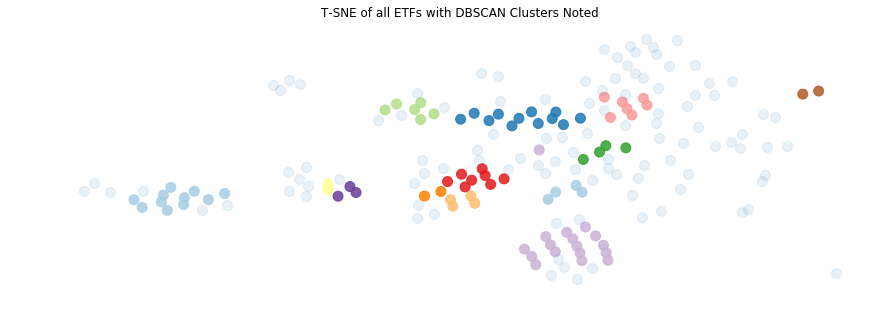

In [265]:
plot_TSNE(X,clf, clustered_series_all)

What can we conclude??
- First of all, the securities in each cluster are indeed from segments tham seem to be fundamentally related.
- Moreover, we see that some filtering is being performed, and the clustering goes further than a simple groupby segment would.

Let's proceed to plot the identified time series.

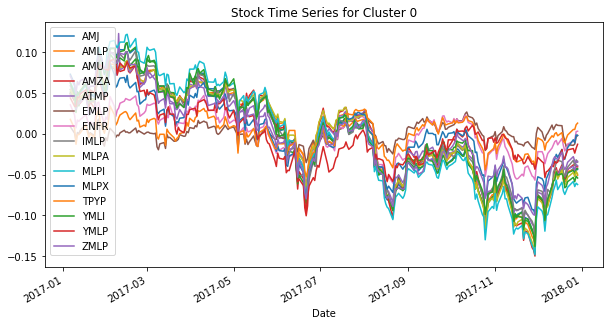

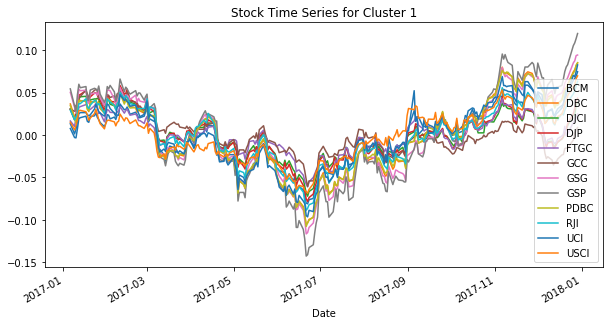

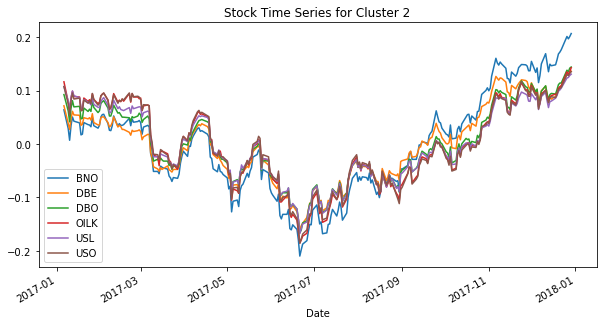

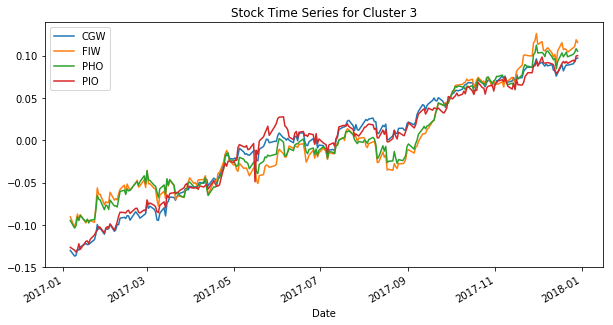

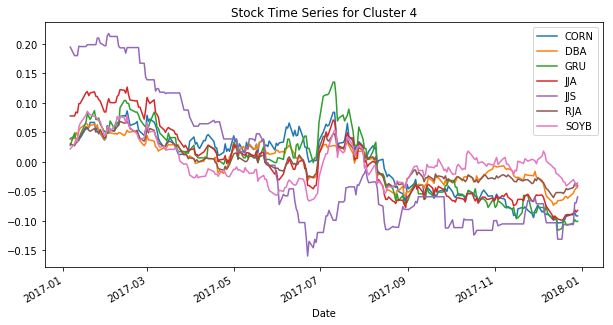

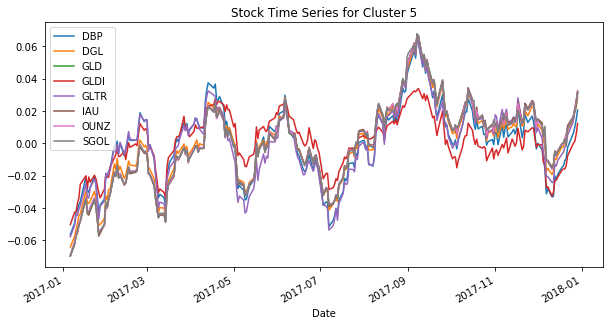

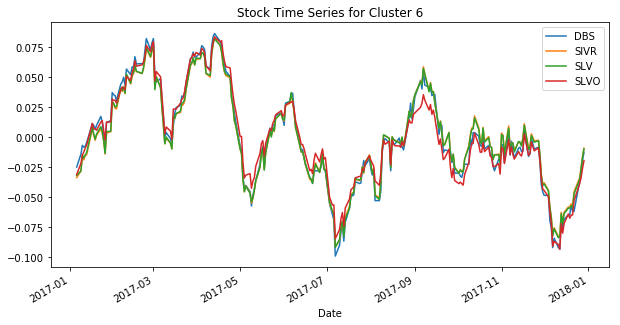

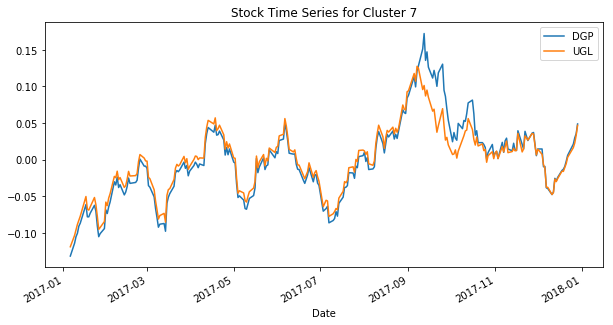

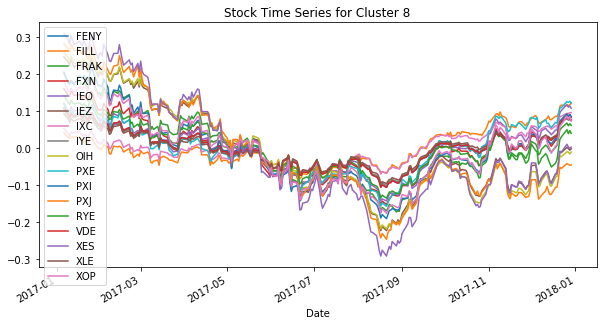

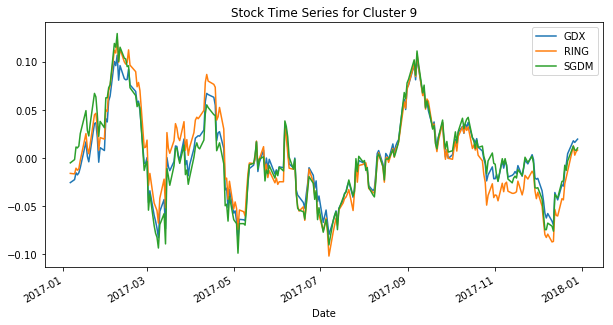

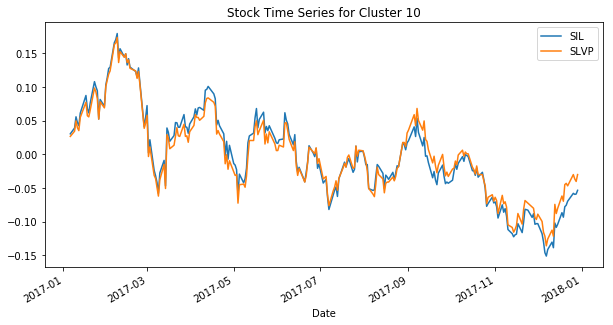

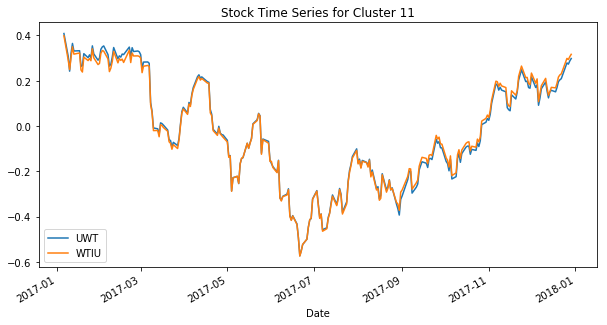

In [266]:
for clust in range(len(counts)):
    symbols = list(clustered_series[clustered_series==clust].index)
    means = np.log(etfs_pricing[symbols].mean())
    series = np.log(etfs_pricing[symbols]).sub(means)
    series.plot(title='Stock Time Series for Cluster %d' % clust, figsize=(10,5))

We now investigate whether it is possible to find cointegrated pairs within the clusters

In [267]:
total_pairs, unique_tickers = series_analyzer.get_candidate_pairs(clustered_series=clustered_series,
                                                            pricing_df=etfs_pricing,
                                                            n_clusters=len(counts),
                                                            min_half_life=config['pair_restrictions']['min_half_life'],
                                                            min_zero_crosings=config['pair_restrictions']['min_zero_crossings'],
                                                            p_value_threshold=config['pair_restrictions']['p_value_threshold'],
                                                            hurst_threshold=config['pair_restrictions']['hurst_threshold']
                                                            )

Found 71 pairs
The pairs contain 44 unique tickers


In [278]:
lookback_multiplier= config['trading']['lookback_multiplier']
entry_multiplier= config['trading']['entry_multiplier']
exit_multiplier= config['trading']['exit_multiplier']
# obtain trading filter info
if config['trading_filter']['active'] == 1:
    trading_filter = config['trading_filter']
else:
    trading_filter = None

**Applying Bollinger Bands**

In [279]:
sharpe_results_bollinger, cum_returns_bollinger, performance_bollinger = trader.apply_bollinger_strategy(total_pairs,
                                                                                         lookback_multiplier,
                                                                                         entry_multiplier,
                                                                                         exit_multiplier,
                                                                                         trading_filter
                                                                                         )



AMJ,AMZA
APR 0.033925312735191726
Sharpe 1.4639347089579307


AMJ,EMLP
APR 0.055778374487256865
Sharpe 1.6849951320510328


AMJ,ENFR
APR 0.013295267288332635
Sharpe 0.4141173772699092


AMJ,MLPX
APR -0.0068055272849629755
Sharpe -0.23378488383775115


AMJ,TPYP
APR 0.06861806236236023
Sharpe 1.7062554025009256


AMLP,EMLP
APR 0.06576928767370682
Sharpe 1.7129061734708866


AMLP,ENFR
APR -0.0018166075846557383
Sharpe -0.03437122793531572


AMLP,MLPI
APR -0.00664040767233931
Sharpe -0.34183078375749204


AMLP,TPYP
APR 0.04366144894705726
Sharpe 1.1244653850049557


AMLP,YMLI
APR 0.04156097812966353
Sharpe 1.3086390005182877


AMU,AMZA
APR 0.0318845709972706
Sharpe 1.3294279459585525


AMU,EMLP
APR 0.04524238069837527
Sharpe 1.3240174647887548


AMU,ENFR
APR 0.005414758045421131
Sharpe 0.17825009812687417


AMU,MLPX
APR 0.0055595236864318665
Sharpe 0.19876928549733222


AMU,TPYP
APR 0.05883399555906732
Sharpe 1.5123760191359368


AMZA,EMLP
APR 0.07097724298205055
Sharpe 1.793347990723118

APR 0.06567932301581236
Sharpe 1.9699652095842926


PXI,RYE
APR 0.033618076171394895
Sharpe 1.130887397674031


PXI,XOP
APR 0.02110582747846257
Sharpe 0.9120909407555768


RYE,XOP
APR 0.026947950951092148
Sharpe 0.9540946312638517


GDX,SGDM
APR 0.003736012076516415
Sharpe 0.14630243747164481


**Bollinger Bands Performance**

Sharpe Ratio Results: 
Average result:  0.8746563241748255


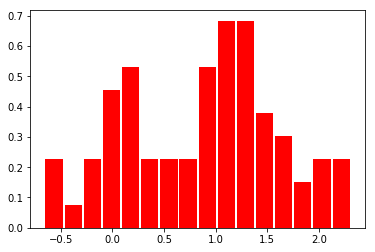

In [270]:
print('Sharpe Ratio Results: ')
n, bins, patches = plt.hist(sharpe_results_bollinger, bins = 16, normed=True, orientation='vertical',
                            color='red', rwidth=0.9, align='mid')
print('Average result: ', np.mean(sharpe_results_bollinger))

In [271]:
print('ROI: ', np.mean(cum_returns_bollinger))

ROI:  3.067820219414045


**Applying the Kalman filter based strategy**

In [272]:
entry_multiplier= config['trading']['entry_multiplier']
exit_multiplier= config['trading']['exit_multiplier']

sharpe_results_kalman, cum_returns_kalman, performance_kalman = trader.apply_kalman_strategy(total_pairs, 
                                                                                             entry_multiplier,
                                                                                             exit_multiplier,
                                                                                             trading_filter)



AMJ,AMZA
APR 0.008609155207923713
Sharpe 0.8836844232180374


AMJ,EMLP
APR 0.00958735535718458
Sharpe 0.4075185332101244


AMJ,ENFR
APR 0.026305961658584565
Sharpe 1.2831601798956087


AMJ,MLPX
APR 0.014914041679716883
Sharpe 1.2306596403745802


AMJ,TPYP
APR 0.011908576601796561
Sharpe 0.8273986476855321


AMLP,EMLP
APR -0.008361127007141755
Sharpe -0.22118519694448113


AMLP,ENFR
APR 0.08039044506397253
Sharpe 2.327996724885377


AMLP,MLPI
APR 0.004699356498791607
Sharpe 0.5334306693647716


AMLP,TPYP
APR 0.06047264859948687
Sharpe 2.1431659863511148


AMLP,YMLI
APR 0.041064550430759184
Sharpe 1.7887740144387747


AMU,AMZA
APR 0.010408081439410966
Sharpe 1.0287523863825085


AMU,EMLP
APR -0.018757506780927913
Sharpe -0.5951290750149328


AMU,ENFR
APR 0.06237624661464913
Sharpe 2.346098342142413


AMU,MLPX
APR 0.020972122606757404
Sharpe 1.5450650356827322


AMU,TPYP
APR -0.008695455123938767
Sharpe -0.33688004306804736


AMZA,EMLP
APR -0.010496709368558954
Sharpe -0.191818581881012

Sharpe Ratio Results: 
Average result:  1.1465195038895148


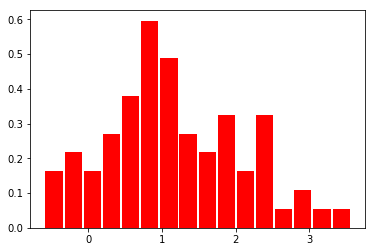

In [273]:
print('Sharpe Ratio Results: ')
n, bins, patches = plt.hist(sharpe_results_kalman, bins = 16, normed=True, orientation='vertical',
                            color='red', rwidth=0.9, align='mid')
print('Average result: ', np.mean(sharpe_results_kalman))

In [275]:
print('ROI: ', np.mean(cum_returns_kalman))

ROI:  2.993272615500188


## Some remarks

- From the analysis above, the Kalman filter method obtains the best performance, with an average Sharpe Ratio larger than 1.
- Different time periods should be tested, to provide information on the variability of these results.
- We should compare this approach with a *compare all against all* approach, to see by which factor our results are improved due to the clustering technique.

**All against all** - *comparing against the simplest strategy*

In [201]:
no_cluster_series = pd.Series(0,index = etfs_pricing.columns)
total_pairs_all_a_all, unique_tickers = series_analyzer.get_candidate_pairs(clustered_series=no_cluster_series,
                                                            pricing_df=etfs_pricing,
                                                            n_clusters=1,
                                                            min_half_life=config['pair_restrictions']['min_half_life'],
                                                            min_zero_crosings=config['pair_restrictions']['min_zero_crossings'],
                                                            p_value_threshold=config['pair_restrictions']['p_value_threshold'],
                                                            hurst_threshold=config['pair_restrictions']['hurst_threshold']
                                                            )
pairs_found_all_a_all = len(total_pairs_all_a_all)
print('Found {} pairs'.format(pairs_found_all_a_all))

Found 273 pairs
The pairs contain 41 unique tickers
Found 273 pairs


Bollinger Bands:

In [203]:
lookback_multiplier= config['trading']['lookback_multiplier']
entry_multiplier= config['trading']['entry_multiplier']
exit_multiplier= config['trading']['exit_multiplier']
# obtain trading filter info
if config['trading_filter']['active'] == 1:
    trading_filter = config['trading_filter']
else:
    trading_filter = None

sharpe_results_boll_aaa, cum_returns_boll_aaa, performance_boll_aaa = trader.apply_bollinger_strategy(total_pairs_all_a_all,
                                                                                         lookback_multiplier,
                                                                                         entry_multiplier,
                                                                                         exit_multiplier,
                                                                                         trading_filter
                                                                                         )



ALTY,DBV
APR -0.019690076598853357
Sharpe -0.37666046873915465


ALTY,DIVA
APR -0.025647640984403308
Sharpe -0.6268695474526955


ALTY,FLAT
APR 0.08703113849382382
Sharpe 2.030807685607455


ALTY,FUT
APR -0.00956969317643086
Sharpe -0.24988167683679713


ALTY,MRGR
APR -0.03981804664306354
Sharpe -1.0451248382719696


ALTY,SIZ
APR 0.04559781673716912
Sharpe 0.9427153906928085


ALTY,STPP
APR -0.04367292586973193
Sharpe -0.5331008817168248


ALTY,TVIX
APR 0.15845242756404643
Sharpe 1.115245313399877


ALTY,UVXY
APR 0.1815796270931438
Sharpe 1.2097981203596972


BTAL,DIVY
APR 0.017862582442937258
Sharpe 0.5720161966008018


BTAL,FUT
APR 0.029607195121189145
Sharpe 0.7547881999532214


BTAL,JPHF
APR 0.013638947462838669
Sharpe 0.448227225572819


CHEP,DIVA
APR 0.04564442310806638
Sharpe 0.8075868719931734


CHEP,DIVY
APR 0.023734801604629485
Sharpe 0.8278376545038248


CHEP,FTLS
APR -0.05475313592423159
Sharpe -0.5285461968372713


CHEP,FUT
APR 0.07843386895838855
Sharpe 0.95411644317309

APR 0.00018772807011280257
Sharpe 0.02526143334356859


DIVA,RINF
APR -0.045554115023159425
Sharpe -0.9852954618389087


DIVA,RLY
APR -0.01896471359405061
Sharpe -0.4051598950197042


DIVA,SIZ
APR 0.04684659395991919
Sharpe 0.9843676193258001


DIVA,STPP
APR 0.08510554058169872
Sharpe 1.4779415908917648


DIVA,TVIX
APR 0.04146312860638357
Sharpe 0.5933366926315745


DIVA,UVXY
APR 0.05205618217328323
Sharpe 0.734026628385942


DIVA,VEGA
APR -0.05642056614856672
Sharpe -1.564124480081488


DIVA,VIIX
APR 0.11407931714193853
Sharpe 1.9963207888977776


DIVA,VIXM
APR 0.10549016666101863
Sharpe 1.729224592760924


DIVA,VIXY
APR 0.10904664755240456
Sharpe 1.8996972497442384


DIVA,WTMF
APR 0.044035992860706585
Sharpe 1.149769501876805


DIVA,XVZ
APR 0.05254693458806314
Sharpe 1.122031104003971


DIVA,ZIV
APR -0.08165630755618969
Sharpe -1.4003938728604428


DIVY,DYB
APR -0.024569195016881595
Sharpe -0.9748186210390113


DIVY,FMF
APR -0.03682071366157491
Sharpe -1.2561063428888681


DIVY,MNA
A

APR -0.013264208326657423
Sharpe -0.2819939172430328


FUT,GAA
APR 0.03096986960422865
Sharpe 0.9009555733700528


FUT,HTUS
APR 0.02303278694396793
Sharpe 0.7388046003734902


FUT,JPHF
APR 0.04081425011189066
Sharpe 1.572016704331324


FUT,MCRO
APR 0.00807815069318174
Sharpe 0.297958642354598


FUT,MNA
APR -0.0033786845322384407
Sharpe -0.11191925393761408


FUT,MOM
APR 0.04525950443613991
Sharpe 1.2925014335620562


FUT,QAI
APR 0.01793785247566615
Sharpe 0.7177366576557209


FUT,QED
APR -0.05365952144185904
Sharpe -2.052228008273042


FUT,QLS
APR -0.015262384741230317
Sharpe -0.4599074662859895


FUT,QMN
APR 0.007898676507078983
Sharpe 0.33744439145744165


FUT,SIZ
APR -0.011701496822161261
Sharpe -0.27763578578786585


FUT,SVXY
APR -0.008735844000838489
Sharpe -0.18056608916994585


FUT,TVIX
APR -0.03348761812613865
Sharpe -0.701280205107946


FUT,UVXY
APR -0.03202798418065267
Sharpe -0.6713121003841697


FUT,VEGA
APR 0.01130011645109752
Sharpe 0.36898880399202194


FUT,VIIX
APR -0.0

APR -0.028810665304430882
Sharpe -1.2156909622290077


MNA,QMN
APR -0.033148208661512135
Sharpe -1.6304147225551633


MNA,SIZ
APR 0.011458415759262097
Sharpe 0.40091680518302564


MNA,STPP
APR -0.01104767493098513
Sharpe -0.35664442759613796


MNA,TVIX
APR -0.23912276535886245
Sharpe -1.199030258589216


MNA,UVXY
APR -0.28672377462857124
Sharpe -1.5504418831513092


MNA,VEGA
APR -0.024743814592359192
Sharpe -1.0502076686306336


MNA,VIIX
APR 0.03360939211634384
Sharpe 0.8987617039516559


MNA,VIXY
APR 0.031560052556113716
Sharpe 0.8232540108156807


MNA,XVZ
APR 0.022780270316132167
Sharpe 0.7999483838926853


MNA,ZIV
APR -0.05309244144173597
Sharpe -1.7050645354947593


MOM,QMN
APR -0.06338503702109777
Sharpe -2.1737886560424227


MOM,TVIX
APR -0.17228317345691957
Sharpe -0.5554809421259133


MOM,UVXY
APR -0.1987058073885467
Sharpe -0.7160483875003189


MOM,VEGA
APR -0.015207803828720112
Sharpe -0.3069874371281602


MRGR,QAI
APR -0.0218363270668418
Sharpe -1.098622853595885


MRGR,QED


APR 0.12781076619854614
Sharpe 0.967694694316533


TVIX,VIXM
APR -0.030107075046490128
Sharpe -0.16383633581407728


TVIX,XVZ
APR 0.11805659011942726
Sharpe 0.5190886067989029


UVXY,VEGA
APR 0.11959576123471938
Sharpe 0.9102157036559749


UVXY,VIXM
APR -0.0444710409582616
Sharpe -0.27552171159037575


UVXY,XVZ
APR 0.44063357459775543
Sharpe 1.0367498642915272


VEGA,VIXM
APR 0.09727167638303924
Sharpe 1.2950686313414943


VIIX,ZIV
APR -0.08401676285230242
Sharpe -0.8172407043595594


VIXY,ZIV
APR -0.13274753935170802
Sharpe -1.3632337600605549


Sharpe Ratio Results (considering entire universe): 
Average result:  -0.2182626320695486


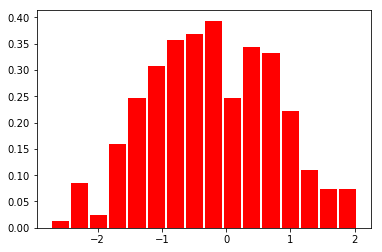

In [205]:
print('Sharpe Ratio Results (considering entire universe): ')
n, bins, patches = plt.hist(sharpe_results_boll_aaa, bins = 16, normed=True, orientation='vertical',
                            color='red', rwidth=0.9, align='mid')
print('Average result: ', np.mean(sharpe_results_boll_aaa))

Kalman filter:

In [690]:
entry_multiplier=2
exit_multiplier=0.5

sharpe_results_kalman_all_a_all, cum_returns_kalman_all_all = apply_kalman_strategy(total_pairs_all_a_all,
                                                                                    entry_multiplier,
                                                                                    exit_multiplier)

NameError: name 'apply_kalman_strategy' is not defined

Sharpe Ratio Results (considering the entire universe): 
Average result:  0.2917998463678402


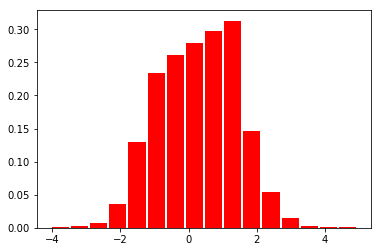

In [84]:
print('Sharpe Ratio Results (considering the entire universe): ')
n, bins, patches = plt.hist(sharpe_results_kalman_all_a_all, bins = 16, normed=True, orientation='vertical',
                            color='red', rwidth=0.9, align='mid')
print('Average result: ', np.mean(sharpe_results_kalman_all_a_all))

### Out of Sample Data

Identified pairs under `unique_tickers`

In [ ]:
initial_date = '01-01-2018'
final_date = '01-01-2019'
data_source = 'yahoo'
error_counter = 0
dataset_ofs = {key: None for key in unique_tickers}
for ticker in unique_tickers:
    try:
        df = data.DataReader(ticker, data_source, initial_date, final_date)
        series = df['Adj Close']; series.name = ticker # filter close price only
        dataset_ofs[ticker] = series.copy()
    except:
        error_counter = error_counter + 1
        print('Not Possible to retrieve information for '+ticker)

**Bollinger Bands Out-of-Sample**

In [ ]:
lookback_multiplier=2
sharpe_results_bollinger_ofs = []
returns_bollinger_ofs = []
for pair in total_pairs:
    print('\n\n{},{}'.format(pair[0], pair[1]))
    coint_result = pair[2]
    pnl, ret, summary, sharpe = trader.bollinger_band_strategy(dataset_ofs[coint_result['Y'].name],
                                                               dataset_ofs[coint_result['X'].name], 
                                                               lookback_multiplier*coint_result['half_life'],
                                                               entry_multiplier=2, exit_multiplier=0.5)
    returns_bollinger_ofs.append(ret)
    sharpe_results_bollinger_ofs.append(sharpe)

In [ ]:
print('Sharpe Ratio Results: ')
n, bins, patches = plt.hist(sharpe_results_bollinger_ofs, bins = 16, normed=True, orientation='vertical',
                            color='red', rwidth=0.9, align='mid')
print('Average Sharpe Ratio: ', np.mean(sharpe_results_bollinger_ofs))

It performs fairly poorly. Let's see how many of the identified pairs actually turned out to be cointegrated during this period.

### The Correlation Filter

The correlation filter aims to track how the correlation between the two legs of tha pair is varing, and provide that information as input to the trading strategy.

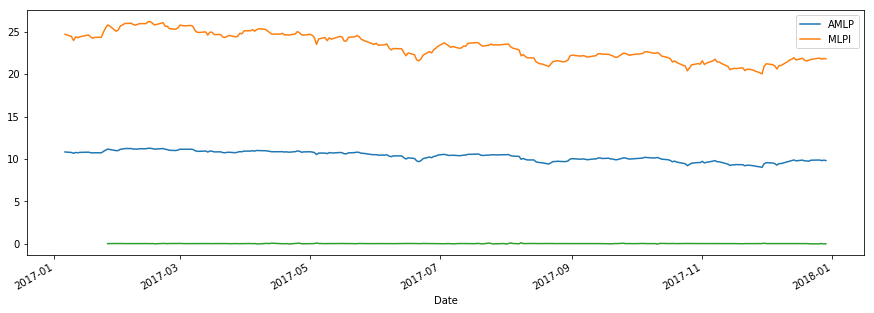

In [466]:
example_pair = failed_pairs[2]

example_pair_leg1 = example_pair[0][0]
example_pair_leg2 = example_pair[0][1]

example_pair_prices = etfs_pricing[[example_pair_leg1, example_pair_leg2]]
example_pair_prices.plot(figsize=(15,5))


# proceed to calculate correlation
rolling_window = config['trading']['lookback_multiplier']*example_pair[0][2]['half_life']

# get returns
example_pair_returns = data_processor.get_return_series(example_pair_prices)

# analyze correlation on returns
example_correlation = example_pair_returns[example_pair_leg1].rolling(rolling_window).corr(example_pair_returns[example_pair_leg2])

# plot correlation of returns
diff_example_correlation = example_correlation.diff(periods=1)
#diff_example_correlation = diff_example_correlation*10
diff_example_correlation.plot()

This result indicates there's almost no correlation between correlation diff and returns... Let's see how this result varies on average:

In [380]:
failure_correlations = []
for failure in failed_pairs:
    failure_df = failure[1][failure[1].units != 0]
    correlation = failure_df['ret'].corr(failure_df['correlation'])
    failure_correlations.append(correlation)
    
print(np.mean(failure_correlations))

-0.04480324434678721


However, we are not realyy interested in the correlation of the the diff column, but rather on the correlation with its sign.

In [376]:
failure_correlations = []
for failure in failed_pairs:
    failure_df = failure[1][failure[1].units != 0]
    failure_df['diff_correlation_sign']=failure_df['diff_correlation'].apply(lambda row: -1 if row<0 else 1)
    correlation = failure_df['ret'].corr(failure_df['diff_correlation_sign'])
    failure_correlations.append(correlation)
    
print(np.mean(failure_correlations))

/Users/simaomoraessarmento/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0.021426798923804273


We could use mutual information rather than correlation as the sign is discrete. What about the relation with the zscore evolution?

### Analyze non-profitable pairs

In [589]:
sharpe_results_bollinger = np.asarray(sharpe_results_bollinger)
negative_pairs_indices = np.argwhere(sharpe_results_bollinger < 0)
print('{} out of {} pairs turned out to be non-profitable'.format(len(negative_pairs_indices), len(total_pairs)))

10 out of 71 pairs turned out to be non-profitable


Let's get some more information on the non-profitable pairs:

In [590]:
negative_pairs = [total_pairs[i] for i in negative_pairs_indices.flatten()]
negative_pairs = [(item[0], item[1]) for item in negative_pairs]
negative_pairs

[('AMJ', 'MLPX'),
 ('AMLP', 'MLPI'),
 ('AMZA', 'ENFR'),
 ('MLPX', 'TPYP'),
 ('DBC', 'FTGC'),
 ('FTGC', 'GSG'),
 ('FTGC', 'PDBC'),
 ('FTGC', 'RJI'),
 ('FIW', 'PHO'),
 ('DBA', 'RJA')]

To what clusters do these pairs belong?

In [591]:
for label_n in range(len(counts)):
    elements_cluster_n = list(clustered_series[clustered_series == label_n].index)
    etfs_cluster_n = etfs_unique[etfs_unique['Ticker'].isin(elements_cluster_n)]
    for pair in negative_pairs:
        if pair[0] in list(etfs_cluster_n.Ticker):
            print('Pair {} belongs to cluster {}'.format(pair, label_n))

Pair ('AMJ', 'MLPX') belongs to cluster 0
Pair ('AMLP', 'MLPI') belongs to cluster 0
Pair ('AMZA', 'ENFR') belongs to cluster 0
Pair ('MLPX', 'TPYP') belongs to cluster 0
Pair ('DBC', 'FTGC') belongs to cluster 1
Pair ('FTGC', 'GSG') belongs to cluster 1
Pair ('FTGC', 'PDBC') belongs to cluster 1
Pair ('FTGC', 'RJI') belongs to cluster 1
Pair ('FIW', 'PHO') belongs to cluster 3
Pair ('DBA', 'RJA') belongs to cluster 4


How do the statistics rank?

In [623]:
sorted_indices = np.flip(np.argsort(sharpe_results_bollinger), axis=0)

# initialize list of lists 
data = []
for index in sorted_indices:
    # get number of positive and negative positions
    position_returns = performance[index][1].position_return
    positive_positions = len(position_returns[position_returns>0])
    negative_positions = len(position_returns[position_returns<0])
    data.append([total_pairs[index][0],
                 total_pairs[index][1],
                 total_pairs[index][2]['t_statistic'],
                 total_pairs[index][2]['p_value'],
                 total_pairs[index][2]['zero_cross'],
                 total_pairs[index][2]['half_life'],
                 total_pairs[index][2]['hurst_exponent'],
                 positive_positions,
                 negative_positions,
                 sharpe_results_bollinger[index]
                ])
      
# Create the pandas DataFrame 
df = pd.DataFrame(data, columns = ['Leg1', 'Leg2', 't_statistic', 'p_value', 'zero_cross',
                                   'half_life', 'hurst_exponent', 'positive trades', 'negative_trades',
                                   'sharpe_result']) 
df

,Leg1,Leg2,t_statistic,p_value,zero_cross,half_life,hurst_exponent,positive trades,negative_trades,sharpe_result
0,EMLP,MLPI,-4.119981,0.000897,34,5,0.117162,19,9,2.425467
1,PXE,XLE,-2.944452,0.040418,21,11,0.132905,9,2,2.404698
2,AMJ,AMZA,-2.998947,0.034993,24,10,0.175520,9,4,2.010823
3,EMLP,YMLI,-4.061982,0.001119,28,5,0.113669,17,10,1.879715
4,EMLP,IMLP,-4.083088,0.001033,28,5,0.115862,20,9,1.857711
5,MLPI,TPYP,-3.730445,0.003705,36,6,0.152077,14,4,1.837709
6,EMLP,MLPX,-3.912173,0.001947,25,6,0.098952,14,7,1.813720
7,TPYP,YMLI,-3.796505,0.002943,28,6,0.138340,15,6,1.746730
8,AMLP,EMLP,-4.107690,0.000941,34,5,0.119430,20,7,1.743644
9,AMJ,TPYP,-3.755516,0.003397,38,6,0.151137,13,7,1.718024


In [593]:
# analyze correlations
print('Half-life vs Sharpe Ratio correlation: ', df['sharpe_result'].corr(df['half_life']))
print('Zero crossings vs Sharpe Ratio correlation: ', df['sharpe_result'].corr(df['zero_cross']))
print('p-value vs Sharpe Ratio correlation: ', df['sharpe_result'].corr(df['p_value']))
print('t-statistic vs Sharpe Ratio correlation: ', df['sharpe_result'].corr(df['t_statistic']))
print('Hurst exponent vs Sharpe Ratio correlation ', df['sharpe_result'].corr(df['hurst_exponent']))

Half-life vs Sharpe Ratio correlation:  -0.32182336045579807
Zero crossings vs Sharpe Ratio correlation:  -0.11839381958282873
p-value vs Sharpe Ratio correlation:  -0.3650197578162554
t-statistic vs Sharpe Ratio correlation:  -0.40421527393166984
Hurst exponent vs Sharpe Ration correlation  -0.34804930252364047


Are there any signs these pairs were not profitable as the strategy evolves? Could we have predicted their lack of profitability?
- Using a ML algorithm that recognizes when a pair is not profitable anymore.
- Checking how the hurst exponent has been changing.
- Analyze their previous positions' returns

In [37]:
performance_bollinger[0][1][36:]

,pnl,ret,spread,AMZA,AMJ,zscore,current_position,position_return
Date,,,,,,,,
2017-03-01,0.000000,0.000000,1.483112,7.388008,28.788561,NaN,0.0,0.000000
2017-03-02,0.000000,0.000000,2.331933,7.401095,28.710335,NaN,0.0,0.000000
2017-03-03,0.000000,0.000000,2.628563,7.401095,28.684263,NaN,0.0,0.000000
2017-03-06,0.000000,0.000000,2.796648,7.414185,28.719028,0.891900,0.0,0.000000
2017-03-07,0.000000,0.000000,2.969386,7.394551,28.614721,1.028821,0.0,0.000000
2017-03-08,0.029830,0.002524,3.058205,7.280036,28.067114,1.081804,-1.0,0.000000
2017-03-09,0.013779,0.001198,3.075901,7.230956,27.832424,1.070933,-1.0,0.000000
2017-03-10,0.015062,0.001323,2.938429,7.214596,27.823729,0.953145,-1.0,0.000000
2017-03-13,-0.012352,-0.001075,2.819490,7.230956,27.849806,0.846794,-1.0,0.000000
